# Exercise IV: Function Approximation
>You will use function approximation to device controllers for the mountain car and/or cart pole problems in Assignment IV.

>Rather than code a function approximation class (straightforward but outside of the scope of our course), you'll use a library, TensorFlow, for this.

>There are two front ends for TensorFlow that make it easier to construct, debug, etc., neural networks (general nonlinear function approximation structures): Keras (keras.io) and TfLearn (tflearn.org).

>Consult the documentation for these two (either, your choice) and learn how to:

>* Construct a neural network with several layers
>* Obtain the gradient of the neural network with respect to its parameters
>* Train the neural network by stochastic gradient descent using a loop that you construct and in which you update the weights as per the gradient and the error (you will use this in A-IV)

>Submit, via pdf, the results of your investigation. Graded for completion; this is an opportunity for you to ask questions in case you are stuck.

>Consult Files/stochastic_gradient_descent_example.py for one example to help you get started.



In [18]:
import gym
import numpy as np
from collections import deque
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import matplotlib.pyplot as plt
import pandas as pd

##Carte Pole

In [2]:
#Set up the environment
env = gym.make("CartPole-v0")
env.reset()


for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done)

  if done:
    break
    
env.close()
print("Iterations that were run:",i)

step i 0 action= 1
obs= [ 0.03659704  0.14841942 -0.0094883  -0.27563865] reward= 1.0 done= False
step i 1 action= 0
obs= [ 0.03956543 -0.04656588 -0.01500108  0.01403662] reward= 1.0 done= False
step i 2 action= 0
obs= [ 0.03863411 -0.24146952 -0.01472034  0.30194903] reward= 1.0 done= False
step i 3 action= 0
obs= [ 0.03380472 -0.43637861 -0.00868136  0.58995337] reward= 1.0 done= False
step i 4 action= 1
obs= [ 0.02507715 -0.24113619  0.0031177   0.29454848] reward= 1.0 done= False
step i 5 action= 0
obs= [ 0.02025443 -0.43630245  0.00900867  0.58821305] reward= 1.0 done= False
step i 6 action= 1
obs= [ 0.01152838 -0.24130781  0.02077293  0.29838147] reward= 1.0 done= False
step i 7 action= 0
obs= [ 0.00670222 -0.43671961  0.02674056  0.59754274] reward= 1.0 done= False
step i 8 action= 1
obs= [-0.00203217 -0.24198185  0.03869142  0.31340132] reward= 1.0 done= False
step i 9 action= 1
obs= [-0.00687181 -0.04743183  0.04495945  0.03316713] reward= 1.0 done= False
step i 10 action= 0


##Training: Nerual Network

In [17]:
class QNetwork():
    def __init__(self, state_dim, action_size):
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
        self.q_state = tf.layers.dense(self.hidden1, action_size, activation=None)
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1)
        
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run(self.optimizer, feed_dict=feed)
        
    def get_q_state(self, session, state):
        q_state = session.run(self.q_state, feed_dict={self.state_in: state})
        return q_state

In [20]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [21]:
def get_action(env, state, epsilon, q_network, sess):
    #e-greedy
    if np.random.random() < epsilon:
        action = np.random.randint(env.action_space.n)
    else:
        q_state = q_network.get_q_state(sess, [state])
        action = np.argmax(q_state)
    return action

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


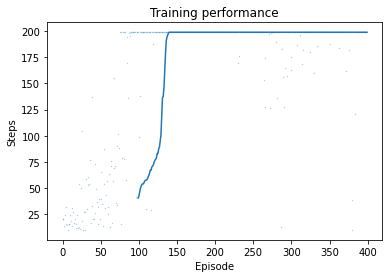

In [13]:
state_dim = env.observation_space.shape
action_size = env.action_space.n
q_network = QNetwork(state_dim, action_size)
replay_buffer = ReplayBuffer(maxlen=10000)
gamma = 0.97
eps = 1.0
sess = tf.Session()
sess.run(tf.global_variables_initializer())

num_episodes = 400
steps = np.zeros(num_episodes)
for episode in range(num_episodes):
    state = env.reset()
    done = False
    for i in range(5000):
        action = get_action(env, state, eps, q_network, sess)
        next_state, reward, done, info = env.step(action)
        replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = replay_buffer.sample(50)
        q_next_states = q_network.get_q_state(sess, next_states)
        q_next_states[dones] = np.zeros([action_size])
        q_targets = rewards + gamma * np.max(q_next_states, axis=1)
        q_network.update_model(sess, states, actions, q_targets)
        state = next_state
        if done: 
            eps = max(0.1, 0.99*eps)
            steps[episode] = i
            break

plt.scatter(range(len(steps)),steps, s=0.1, alpha=0.5)
plt.plot(range(len(steps)), pd.Series(steps).rolling(100).median())
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Training performance")
plt.show()

In [16]:
#test
print("testing:")
for episode in range(10):
  state = env.reset()

  for i in range(5000):
    q_state = q_network.get_q_state(sess, [state])
    action = np.argmax(q_state)
    state, reward, done, info = env.step(action)
    if done:
      print(f"Episode {episode} lasted {i} steps")
      break
    
  env.close()

testing:
Episode 0 lasted 199 steps
Episode 1 lasted 199 steps
Episode 2 lasted 188 steps
Episode 3 lasted 199 steps
Episode 4 lasted 199 steps
Episode 5 lasted 192 steps
Episode 6 lasted 199 steps
Episode 7 lasted 199 steps
Episode 8 lasted 193 steps
Episode 9 lasted 199 steps
